In [1]:
import numpy as np
import cv2
import os

from scipy import ndimage
from scipy.io import savemat
import matplotlib.pyplot as plt

c:\Users\owner\anaconda3\envs\hyp3dimaging\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
vmin=520
vmax=1400
cmap='nipy_spectral'
res_path = './results'
# dat_path = './experiments/crop_0419/calibration6/'
dat_path = './experiments/test_2023_04_22_21_34_crop/calibration16'

binning = 2

#  D/fine the size of the image
PROJ_WIDTH = 1280 // binning
PROJ_HEIGHT = 720 // binning

# cam_H, cam_W = 1536//binning, 2048//binning
cam_H, cam_W = 580, 890

# Structured light

In [3]:
def read_epi_gc(dat_path, prefix):
    N_gc = 40 # number of graycode images

    # load captured patterns
    cap_roi = []
    for i in range(N_gc):
        fn = os.path.join(dat_path, '%s_%04d.png'%(prefix, i))
        im_roi = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)*2
        cap_roi.append(im_roi)
        
    return cap_roi

def estimate_depth_graycode(cap):
    # parameters
    cam_shape = (cam_H, cam_W) # row, column
    proj_shape = (PROJ_HEIGHT, PROJ_WIDTH) # row, column
    N_gc = 40 # number of graycode images
    N_tot = N_gc  # number of capture images (graycode + white + black)
    gc_step = 1 # should be 1 
    black_thr = 0
    white_thr = 0
    
    # captured patterns
    
    # dmap_SL = estimate_depth_graycode(roi2, im)

    # prepare simulation patterns
    gc_height = int((proj_shape[0]-1)/gc_step)+1
    gc_width = int((proj_shape[1]-1)/gc_step)+1
    graycode = cv2.structured_light_GrayCodePattern.create(gc_width, gc_height)
    graycode.setBlackThreshold(black_thr)
    graycode.setWhiteThreshold(white_thr)
    sim = graycode.generate()[1]
    sim_w = np.ones(proj_shape)
    sim_b = np.zeros(proj_shape)
    
    R,C = cam_H, cam_W
    cap_w = cap[-2]
    cap_b = cap[-1]
    
    # estimate the correspondence map
    corr = np.zeros((cam_shape[0], cam_shape[1], 2))
    cam_pts = []
    prj_pts = []
    valid_mask = np.zeros(cam_shape)
    for r in range(cam_shape[0]):
        if r%100 == 0:
            print('decoding %.2f'%(r/cam_shape[0]))
        for c in range(cam_shape[1]):
            err, proj_pix = graycode.getProjPixel(cap, c, r)
            if not err:
                corr[r,c] = np.array(proj_pix)
                cam_pts.append((c,r))
                prj_pts.append((proj_pix[0],proj_pix[1]))
                valid_mask[r,c] = True
    
    # load the geometric calibration data
    camproj_calib_path = './calibration_propcam.xml'
    fs = cv2.FileStorage(camproj_calib_path, cv2.FileStorage_READ)
    img_shape = fs.getNode("img_shape").mat()
    cam_int = fs.getNode("cam_int").mat()
    cam_dist = fs.getNode("cam_dist").mat()
    proj_int = fs.getNode("proj_int").mat()
    proj_dist = fs.getNode("proj_dist").mat()
    cam_proj_rmat = fs.getNode("rotation").mat()
    cam_proj_tvec = fs.getNode("translation").mat()
    F = fs.getNode("fundamental").mat()
    E = fs.getNode("epipolar").mat()

    # undistort points using calibration
    cam_pts = np.array(cam_pts, dtype=np.float32) 
    cam_pts = cam_pts.reshape((-1, 1, 2))
    cam_pts_n = cv2.undistortPoints(cam_pts, cam_int, cam_dist, P=cam_int)
    prj_pts = np.array(prj_pts, dtype=np.float32) 
    prj_pts = prj_pts.reshape((-1, 1, 2))
    prj_pts_n = cv2.undistortPoints(prj_pts, proj_int, proj_dist, P=proj_int)
    
    # triangulate
    P0 = np.dot(cam_int, np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0]]))
    P1 = np.concatenate((np.dot(proj_int, cam_proj_rmat), np.dot(proj_int,cam_proj_tvec)), axis = 1)
    triang_res = cv2.triangulatePoints(P0, P1, cam_pts_n, prj_pts_n)
    # cam coord 3d points
    points_3d = cv2.convertPointsFromHomogeneous(triang_res.T).squeeze()
    
    # xyz 
    cam_pts = cam_pts.astype(np.int16)
    xyz = np.zeros((R,C,3))
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 0]=points_3d[:,0]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 1]=points_3d[:,1]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 2]=points_3d[:,2]
    
    return xyz

In [4]:
im = read_epi_gc(dat_path, 'capture')
# im = read_epi_gc('/projects/FHEIDE/polar/captured_data_cam_prj/20210114_lion_bust', 'graycode0000')

In [5]:
# print(im[0].shape,roi2)

In [6]:
cam_W

890

In [7]:
# dmap_SL = estimate_depth_graycode(roi2, im)
dmap_SL = estimate_depth_graycode(im)

decoding 0.00
decoding 0.17
decoding 0.34
decoding 0.52
decoding 0.69
decoding 0.86


In [8]:
dmap_SL[...,2].min()

-2185038.75

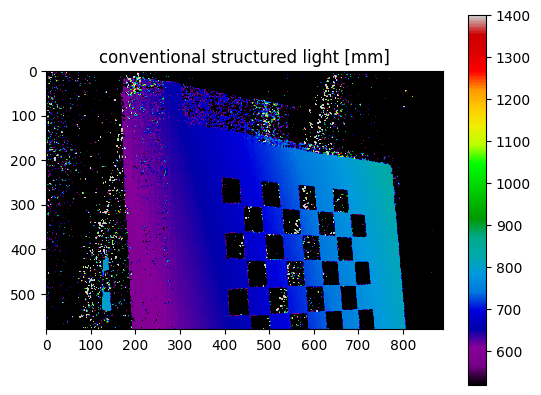

In [9]:
plt.imshow(dmap_SL[...,2],vmin=vmin,vmax=vmax, cmap=cmap)
plt.title('conventional structured light [mm]')
plt.colorbar()
plt.savefig(os.path.join(res_path,'dmap_SL.svg'))
plt.show()

savemat('dmap_SL.mat', {'dmap_SL':dmap_SL})

# nmap_SL = surface_normal_xyz(dmap_SL, kfilt=5, dsize=11)
# plt.imshow((nmap_SL+1)/2)
# plt.title('conventional structured light XYZ normals')
# plt.savefig(os.path.join(res_path,'nmap_SL.svg'))
# plt.show()

# savemat('nmap_SL.mat', {'nmap_SL':nmap_SL})

In [10]:
dmap_SL = dmap_SL*1e-3

In [11]:
vis = dmap_SL.reshape(-1,3)

In [12]:
vis.shape

(516200, 3)

In [13]:
def draw_setup(elev,azi):
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection = '3d')
    ax.set_xlim([-1,1]) #-0.08,0.005    
    ax.set_ylim([-1,1]) #-0.02,0.02    
    ax.set_zlim([0,2])
    for i in range(0,vis.shape[0],100):
        # projector points       
        depth_points = ax.scatter(vis[i,0],vis[i,1],vis[i,2], marker = '.',  c = vis[i,2], s = 1, vmin=0,vmax=1.4, cmap=cmap)
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')
        ax.set_zlabel('z-axis')
        plt.xticks(rotation=45)
        plt.yticks(rotation =90)
        ax.view_init(elev, azi)
    plt.colorbar(depth_points,ax = ax, shrink = 0.5, aspect = 5)
# draw_setup(0, 90)
# draw_setup(0,45)
# draw_setup(45,45)

### Find Depth

In [14]:
cam_shape = (cam_H, cam_W) # row, column
proj_shape = (PROJ_HEIGHT, PROJ_WIDTH) # row, column

In [15]:
cam_pts = []
prj_pts = []

In [16]:
# load the geometric calibration data
camproj_calib_path = './calibration_propcam.xml'
fs = cv2.FileStorage(camproj_calib_path, cv2.FileStorage_READ)
img_shape = fs.getNode("img_shape").mat()
cam_int = fs.getNode("cam_int").mat()
cam_dist = fs.getNode("cam_dist").mat()
proj_int = fs.getNode("proj_int").mat()
proj_dist = fs.getNode("proj_dist").mat()
cam_proj_rmat = fs.getNode("rotation").mat()
cam_proj_tvec = fs.getNode("translation").mat()
F = fs.getNode("fundamental").mat()
E = fs.getNode("epipolar").mat()

# cam_pts = [[128,219],[126,389],[125,559],[809,217],[810,386],[812,557]]
# prj_pts = [[98,95],[99,198],[100,300],[505,94],[504,197],[503,300]]

cam_pts = [[131,223],[127,389],[124,560],[801,222],[805,383],[808,557]]
prj_pts = [[100,100],[100,200],[100,300],[500,100],[500,200],[500,300]]

print(cam_pts)
print(prj_pts)

# undistort points using calibration
cam_pts = np.array(cam_pts, dtype=np.float32) 
cam_pts = cam_pts.reshape((-1, 1, 2))
cam_pts_n = cv2.undistortPoints(cam_pts, cam_int, cam_dist, P=cam_int)
print(cam_pts_n)
prj_pts = np.array(prj_pts, dtype=np.float32) 
prj_pts = prj_pts.reshape((-1, 1, 2))
prj_pts_n = cv2.undistortPoints(prj_pts, proj_int, proj_dist, P=proj_int)
print(prj_pts_n)
# triangulate
P0 = np.dot(cam_int, np.array([[1,0,0,0],
                                [0,1,0,0],
                                [0,0,1,0]]))
P1 = np.concatenate((np.dot(proj_int, cam_proj_rmat), np.dot(proj_int,cam_proj_tvec)), axis = 1)
triang_res = cv2.triangulatePoints(P0, P1, cam_pts_n, prj_pts_n)
# triang_res = cv2.triangulatePoints(P0, P1, cam_pts, prj_pts)

# cam coord 3d points
points_3d = cv2.convertPointsFromHomogeneous(triang_res.T).squeeze()

[[131, 223], [127, 389], [124, 560], [801, 222], [805, 383], [808, 557]]
[[100, 100], [100, 200], [100, 300], [500, 100], [500, 200], [500, 300]]
[[[128.72551 222.12012]]

 [[124.90274 389.3352 ]]

 [[120.72912 562.32623]]

 [[805.0305  220.7076 ]]

 [[808.81384 383.44263]]

 [[813.19946 560.0136 ]]]
[[[102.81249 101.74119]]

 [[102.03841 200.89432]]

 [[101.64479 300.19528]]

 [[504.90414  97.57749]]

 [[503.6481  198.97382]]

 [[503.4815  299.91467]]]


In [17]:
points_3d

array([[-91.65407  , -38.334957 , 526.8624   ],
       [-92.591034 ,  11.994973 , 525.1396   ],
       [-93.75596  ,  63.650444 , 524.36285  ],
       [111.94232  , -38.008156 , 525.5504   ],
       [111.54714  ,  10.8094425, 518.87775  ],
       [110.95808  ,  61.287106 , 509.7527   ]], dtype=float32)

In [18]:
cam_proj_rmat

array([[ 0.99286293,  0.0066195 ,  0.1190772 ],
       [ 0.00475939,  0.99546384, -0.09502153],
       [-0.11916604,  0.0949101 ,  0.98832764]])

In [19]:
cam_proj_tvec

array([[-62.17763073],
       [-12.62577828],
       [ -1.68096196]])

In [20]:
import numpy as np
ext_proj = np.zeros((4,4))
ext_proj[:3,:3] = cam_proj_rmat
t_mtrx = cam_proj_tvec*1e-3
ext_proj[:3,3:4] = t_mtrx
ext_proj[3,3] = 1.

In [21]:
ext_proj

array([[ 0.99286293,  0.0066195 ,  0.1190772 , -0.06217763],
       [ 0.00475939,  0.99546384, -0.09502153, -0.01262578],
       [-0.11916604,  0.0949101 ,  0.98832764, -0.00168096],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [22]:
points_3d*1e-3

array([[-0.09165407, -0.03833496,  0.52686244],
       [-0.09259104,  0.01199497,  0.52513963],
       [-0.09375596,  0.06365044,  0.52436286],
       [ 0.11194233, -0.03800816,  0.5255504 ],
       [ 0.11154715,  0.01080944,  0.51887774],
       [ 0.11095808,  0.06128711,  0.5097527 ]], dtype=float32)

In [23]:
ones = np.ones(shape=(6,1))
points1_3d = np.concatenate((points_3d*1e-3, ones), axis = 1)

In [24]:
points1_3d = points1_3d.transpose(1,0)

In [25]:
proj_points1_3d = ext_proj@points1_3d

In [26]:
proj_points1_3d

array([[-9.06940127e-02, -9.14962843e-02, -9.24034527e-02,
         1.11295236e-01,  1.10431462e-01,  1.09094152e-01],
       [-1.01286339e-01, -5.10254665e-02,  4.63951769e-04,
        -9.98673549e-02, -5.06390317e-02,  4.73932352e-04],
       [ 5.26315432e-01,  5.29501202e-01,  5.33774946e-01,
         5.00787968e-01,  4.98873549e-01,  4.94716043e-01],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00]])